# Introduction

Basically we are trying to find the best algorithm to classify the inhibitor types in our binary dataset from KinCoRe that we preprocessed. Here, we are trying out using Logistic Regression, Support Vector Machine, and Random Forest.

The workflow is as follows:
1. load packages, directory, and dataset
2. find the best combination of sampling and standardization/normalization methods that yields the best baseline model
3. run hyperparameter tuning for our model to get the highest metrics score
4. repeat with different algorithms

# Load dataset and directories

In [1]:
# general data analysis packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# file management packages
import csv, sys
import os
import copy
import pickle

# sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# modeling
from sklearn import preprocessing, model_selection, feature_selection, metrics
from sklearn.feature_selection import f_classif, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer, PowerTransformer, QuantileTransformer, RobustScaler, StandardScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance

# misc
from textwrap import wrap
import time


In [2]:
os.chdir('../data')

In [3]:
data_db = pd.read_csv('data_binding_desc.csv')
data_db

,Unnamed: 0,lig_smiles,LigandType,lig_at,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,CNC(=O)c1c(C)oc2cc(Oc3ccnc4cc(OCCN5CCOCC5)ccc3...,Type3,2169,12.178672,-0.173135,12.178672,0.173135,0.442423,461.518,...,0,0,0,0,0,0,0,0,0,0
1,1,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1,313,11.019783,-1.142046,11.019783,0.138918,0.584168,296.234,...,0,0,0,0,0,0,0,0,0,0
2,2,O=C(O)c1cc2cc3ccc4oc(C(=O)O)cc4c3cc2o1,Type1.5_Back,332,11.019783,-1.142046,11.019783,0.138918,0.584168,296.234,...,0,0,0,0,0,0,0,0,0,0
3,3,COc1cc(Nc2nccc(Nc3cnc4ccccc4c3)n2)ccc1N1CCOCC1,Type2,60001,5.632207,0.490670,5.632207,0.490670,0.468745,428.496,...,0,0,0,0,0,0,0,0,0,0
4,4,Cc1cc(Nc2nn(C(C)C)c(=O)c3cc(N4CCN(C)CC4)ccc23)...,Type1,1,13.089887,-0.065059,13.089887,0.036424,0.722645,381.484,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4214,4576,COc1cc(Nc2cc(Oc3cc(C)c(C)nc3-c3ccccn3)ccn2)cc(...,Type1,61500,6.252538,0.518412,6.252538,0.518412,0.358838,458.518,...,0,0,0,0,0,0,0,0,0,0
4215,4577,NC(=O)c1ccc(-c2cc(-c3cccc4c3OCO4)cnc2N)cc1,Type1,1513,11.222610,-0.469079,11.222610,0.204548,0.767397,333.347,...,0,0,0,0,0,0,0,0,0,0
4216,4578,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1389,14.647223,-1.022970,14.647223,0.109453,0.384505,476.870,...,0,0,0,0,0,0,0,0,0,0
4217,4579,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,Type1,1001,14.647223,-1.022970,14.647223,0.109453,0.384505,476.870,...,0,0,0,0,0,0,0,0,0,0


from here we can see that there are several columns that need to be dropped for the next step, such as `Unnamed: 0` and `lig_smiles`. The column `LigandType` needs to be separated as a target. The rest (209 columns) are features we'll use in the model.

# 0. preprocess data

workflow in this step is the following:
1. drop duplicate and null rows
2. drop feature that begins with `Unnamed` (since it was generated automatically when we did not reset the index in the last step before saving the data from the previous step into csv)
3. encode target using integer (0,1)
4. separate features and target
5. remove features which values don't have variation
6. remove feature that has low correlation with other features
7. split data into train-validation and test set
8. split data into train and validation set

In [4]:
def data_preprocessing(data,
                       target='LigandType', 
                       col_to_drop=['lig_smiles'],
                       test_size=0.2, 
                       val_size=0.2, 
                       random_state=0,
                       anova=True,
                       ):
    '''
    preprocess data from the previous workflow

    Args:
    ----------
      data: pd.DataFrame
        the input data to be preprocesed
      target: str
        target column for the model
      col_to_drop: list
        list of columns to drop
      test_size: float
        test size from the whole input data
      val_size: float
        validation set size from the whole input data
      anova: bool
        initial feature selection option using ANOVA

    Returns:
    ----------
      X_train, X_val, X_test, y_train, y_val, y_test: np.array
        the respective train, validation and test sets
      descnm: np.array
        feature names
    '''

    # drop duplicate rows
    data_ = data.drop_duplicates().dropna()

    # drop cols with 'unnamed'
    colidx_to_drop = [i for i in data.columns if 'Unnamed' in i]

    #encode target
    to_mask = {}

    for i,j in enumerate(data_[target].unique()):
        to_mask.update({j:i})

    data_ = data_.replace(to_mask)

    # separate x and y
    X = data_.loc[:, data_.columns.difference(col_to_drop+[target]+colidx_to_drop)]
    y = data_[target]

    # remove features that don't have variation
    X_out = X.loc[:,X.apply(pd.Series.nunique) != 1]
    mask = X_out.applymap(lambda x: isinstance(x, (int, float)))
    X_out2 = X_out.where(mask)
    X = X_out2.dropna(axis=1)

    if anova == True:
      # anova feature selection
      f_stat, p_val, = f_classif(X, y)

      # get index which probability is lower than p = 0.05
      idx = [i for i,j in enumerate(p_val) if j < 0.05]
      # select column with respective index
      X = X.iloc[:,idx]
    else:
      pass

    # split train-validation and test
    X_trainval, X_test, y_trainval, y_test = model_selection.train_test_split(X, y, test_size = test_size, random_state=random_state, stratify=y)
    # split train and validation
    X_train, X_val, y_train, y_val = model_selection.train_test_split(X_trainval, y_trainval, test_size = val_size/(1-val_size), random_state=random_state, stratify=y_trainval)

    descnm = np.array(X_train.columns)
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)

    #return X_trainval, X_test, y_trainval, y_test
    return X_train, X_val, X_test, y_train, y_val, y_test, descnm

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_db)

In [6]:
data_da_desc = data_db.drop(columns=['Unnamed: 0', 'lig_smiles', 'LigandType', 'lig_at'])#.describe().T
data_da_desc

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.178672,-0.173135,12.178672,0.173135,0.442423,461.518,434.302,461.195071,176,0,...,0,0,0,0,0,0,0,0,0,0
1,11.019783,-1.142046,11.019783,0.138918,0.584168,296.234,288.170,296.032088,108,0,...,0,0,0,0,0,0,0,0,0,0
2,11.019783,-1.142046,11.019783,0.138918,0.584168,296.234,288.170,296.032088,108,0,...,0,0,0,0,0,0,0,0,0,0
3,5.632207,0.490670,5.632207,0.490670,0.468745,428.496,404.304,428.196074,162,0,...,0,0,0,0,0,0,0,0,0,0
4,13.089887,-0.065059,13.089887,0.036424,0.722645,381.484,354.268,381.227708,148,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4214,6.252538,0.518412,6.252538,0.518412,0.358838,458.518,432.310,458.195405,174,0,...,0,0,0,0,0,0,0,0,0,0
4215,11.222610,-0.469079,11.222610,0.204548,0.767397,333.347,318.227,333.111341,124,0,...,0,0,0,0,0,0,0,0,0,0
4216,14.647223,-1.022970,14.647223,0.109453,0.384505,476.870,461.750,476.085160,168,0,...,0,0,0,0,0,0,0,0,0,0
4217,14.647223,-1.022970,14.647223,0.109453,0.384505,476.870,461.750,476.085160,168,0,...,0,0,0,0,0,0,0,0,0,0


# 1. find combination of sampling and standardization methods for a baseline model

In [14]:
def model_(X_train, y_train, X_val, y_val,
                      algorithm = 'LogisticRegression',
                      multiclass = False,
                      kernel = 'rbf',
                      solver='liblinear',
                      max_iter=10000,
                      sampling = 'SMOTE',
                      scaling = True,
                      random_state=0):
    '''
    Find the best combination of sampling and
    standardization methods as a baseline model.

    Args:
    ----------
        X_train, y_train, X_val, y_val: np.array or pd.DataFrame or pd.Series
            Training and validation data and its targts
        algorithm: str
            The algorithm to use. Available are:
            - Logistic regression: 'logreg'
            - Support vector machine: 'svm'
            - Random forest: 'rf'
        multiclass: bool
            Determining whether the classification is binary or multiclass.
            if `True` then the average metrics is computed as weighted
            if `False` then the average metrics is computed as binary
        kernel: str
            only applies in support vector machine. 
            The kernel you wish to run.
        solver: str
            only applies in logistic regression. 
            The solver you wish to run. Default is 'liblinear'.
        sampling: str
            sampling method you wish to use. Available are:
            - smote
            - random_over
            - random_under
        scaling: bool
            scaling (standardization/normalization) of the data.

    Returns:
    ----------
        dict
            A dictionary of the scores between different sampling and scaling methods 
            across metrics of the training and validation data
    '''

    if type(sampling) == str:
        sampling = [sampling]

    for i in sampling:
        if i == 'RandomUnderSampler':
            X_train, y_train  = RandomUnderSampler(random_state=random_state).fit_resample(X_train, y_train)
        elif i == 'RandomOverSampler':
            X_train, y_train  = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)
        elif i == 'SMOTE':
            X_train, y_train = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
        else:
            pass
    
    if algorithm == 'LogisticRegression':
        model = LogisticRegression(solver=solver, random_state=random_state, max_iter=max_iter)
    elif algorithm == 'SVC':
        model = SVC(kernel=kernel, random_state=random_state)
    else:
        model = RandomForestClassifier(random_state=random_state)
        scaling = False

    # scaling
    if scaling == False:
        train_scaled = {'none':X_train}
    else:
        X_train_MAS = preprocessing.MaxAbsScaler().fit_transform(X_train)
        X_train_MMS = preprocessing.MinMaxScaler().fit_transform(X_train)
        X_train_SS = preprocessing.StandardScaler().fit_transform(X_train)
        X_train_NORM = preprocessing.Normalizer().fit_transform(X_train)
        X_train_NMAS = preprocessing.MaxAbsScaler().fit_transform(X_train_NORM)
        X_train_NMMS = preprocessing.MinMaxScaler().fit_transform(X_train_NORM)
        X_train_NSS = preprocessing.StandardScaler().fit_transform(X_train_NORM)
        X_train_MASNORM = preprocessing.Normalizer().fit_transform(X_train_MAS)
        X_train_MMSNORM = preprocessing.Normalizer().fit_transform(X_train_MMS)
        X_train_SSNORM = preprocessing.Normalizer().fit_transform(X_train_SS)

        train_scaled = {
            'none':X_train,
            'MaxAbsScaler':X_train_MAS,
            'MinMaxScaler':X_train_MMS,
            'StandardScaler':X_train_SS,
            'Normalizer':X_train_NORM,
            'Normalizer + MaxAbsScaler':X_train_NMAS,
            'Normalizer + MinMaxScaler':X_train_NMMS,
            'Normalizer + StandardScaler':X_train_NSS,
            'MaxAbsScaler + Normalizer':X_train_MASNORM,
            'MinMaxScaler + Normalizer':X_train_MMSNORM,
            'StandardScaler + Normalizer':X_train_SSNORM,
            }

    output_dict= {
        'sampling': [],
        'scaling': [],
        'train_accuracy': [],
        'train_f1': [],
        'train_ba':[],
        'train_mcc':[],
        'val_accuracy':[],
        'val_f1':[],
        'val_ba':[],
        'val_mcc':[],
    }

    for sampl in sampling:
        for scaler, scaled in train_scaled.items():
            fit = model.fit(scaled, y_train)
            y_pred = fit.predict(scaled)
            y_val_pred = fit.predict(X_val)
            
            # calculate statistical metrics accuracy for training set
            train_accuracy = metrics.accuracy_score(y_train, y_pred)
            val_accuracy = metrics.accuracy_score(y_val, y_val_pred)

            if multiclass == True:
                # calculate statistical metrics for training set
                train_f1 = metrics.f1_score(y_train, y_pred, average = 'weighted')
                train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
                train_mcc = metrics.matthews_corrcoef(y_train, y_pred)

                # calculate statistical metrics for val set
                val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'weighted')
                val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
                val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
            else:
                # calculate statistical metrics for training set
                train_f1 = metrics.f1_score(y_train, y_pred, average = 'binary')
                train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
                train_mcc = metrics.matthews_corrcoef(y_train, y_pred)

                # calculate statistical metrics for val set
                val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'binary')
                val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
                val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)


            output_dict['sampling'].append(sampl)
            output_dict['scaling'].append(scaler)
            # train metrics
            output_dict['train_accuracy'].append(train_accuracy)
            output_dict['train_f1'].append(train_f1)
            output_dict['train_ba'].append(train_ba)
            output_dict['train_mcc'].append(train_mcc)
            # val metrics
            output_dict['val_accuracy'].append(val_accuracy)
            output_dict['val_f1'].append(val_f1)
            output_dict['val_ba'].append(val_ba)
            output_dict['val_mcc'].append(val_mcc)
    return output_dict



In [21]:
def find_model(X_train, y_train, X_val, y_val,
                algorithm = 'logreg',
                multiclass = False,
                kernel = 'rbf',
                solver='liblinear',
                max_iter=10000,
                scaling = True,
                random_state=0):
    '''
    Find the best combination of sampling and
    standardization methods as a baseline model.

    Args:
    ----------
        X_train, y_train, X_val, y_val: np.array or pd.DataFrame or pd.Series
            Training and validation data and its targts
        algorithm: str
            The algorithm to use. Available are:
            - Logistic regression: 'LogisticRegression'
            - Support vector machine: 'SVC'
            - Random forest: 'RandomForestClassification'
        multiclass: bool
            Determining whether the classification is binary or multiclass.
            if `True` then the average metrics is computed as weighted
            if `False` then the average metrics is computed as binary
        kernel: str
            only applies in support vector machine. 
            The kernel you wish to run.
        solver: str
            only applies in logistic regression. 
            The solver you wish to run. Default is 'liblinear'.
        #sampling: str
        #    sampling method you wish to use. Available are:
        #    - smote
        #    - random_over
        #    - random_under
        scaling: bool
            scaling (standardization/normalization) of the data.

    Returns:
    ----------
        df_find_model
            A DataFrame of the scores between different sampling and scaling methods 
            across metrics of the training and validation data
    '''

    def model_(X_train, y_train, X_val, y_val,
                      algorithm = algorithm,
                      multiclass = multiclass,
                      kernel = kernel,
                      solver = solver,
                      sampling = 'SMOTE',
                      max_iter=max_iter,
                      scaling = scaling,
                      random_state=random_state):
        '''
        Find the best combination of sampling and
        standardization methods as a baseline model.

        Args:
        ----------
            X_train, y_train, X_val, y_val: np.array or pd.DataFrame or pd.Series
                Training and validation data and its targts
            algorithm: str
                The algorithm to use. Available are:
                - Logistic regression: 'logreg'
                - Support vector machine: 'svm'
                - Random forest: 'rf'
            multiclass: bool
                Determining whether the classification is binary or multiclass.
                if `True` then the average metrics is computed as weighted
                if `False` then the average metrics is computed as binary
            kernel: str
                only applies in support vector machine. 
                The kernel you wish to run.
            solver: str
                only applies in logistic regression. 
                The solver you wish to run. Default is 'liblinear'.
            sampling: str
                sampling method you wish to use. Available are:
                - smote
                - random_over
                - random_under
            scaling: bool
                scaling (standardization/normalization) of the data.

        Returns:
        ----------
            dict
                A dictionary of the scores between different sampling and scaling methods 
                across metrics of the training and validation data
        '''

        if type(sampling) == str:
            sampling = [sampling]

        for i in sampling:
            if i == 'RandomUnderSampler':
                X_train, y_train  = RandomUnderSampler(random_state=random_state).fit_resample(X_train, y_train)
            elif i == 'RandomOverSampler':
                X_train, y_train  = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)
            elif i == 'SMOTE':
                X_train, y_train = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
            else:
                pass
        
        if algorithm == 'LogisticRegression':
            model = LogisticRegression(solver=solver, random_state=random_state, max_iter=max_iter)
        elif algorithm == 'SVC':
            model = SVC(kernel=kernel, random_state=random_state)
        else:
            model = RandomForestClassifier(random_state=random_state)
            scaling = False

        # scaling
        if scaling == False:
            train_scaled = {'none':X_train}
        else:
            X_train_MAS = preprocessing.MaxAbsScaler().fit_transform(X_train)
            X_train_MMS = preprocessing.MinMaxScaler().fit_transform(X_train)
            X_train_SS = preprocessing.StandardScaler().fit_transform(X_train)
            X_train_NORM = preprocessing.Normalizer().fit_transform(X_train)
            X_train_NMAS = preprocessing.MaxAbsScaler().fit_transform(X_train_NORM)
            X_train_NMMS = preprocessing.MinMaxScaler().fit_transform(X_train_NORM)
            X_train_NSS = preprocessing.StandardScaler().fit_transform(X_train_NORM)
            X_train_MASNORM = preprocessing.Normalizer().fit_transform(X_train_MAS)
            X_train_MMSNORM = preprocessing.Normalizer().fit_transform(X_train_MMS)
            X_train_SSNORM = preprocessing.Normalizer().fit_transform(X_train_SS)

            train_scaled = {
                'none':X_train,
                'MaxAbsScaler':X_train_MAS,
                'MinMaxScaler':X_train_MMS,
                'StandardScaler':X_train_SS,
                'Normalizer':X_train_NORM,
                'Normalizer + MaxAbsScaler':X_train_NMAS,
                'Normalizer + MinMaxScaler':X_train_NMMS,
                'Normalizer + StandardScaler':X_train_NSS,
                'MaxAbsScaler + Normalizer':X_train_MASNORM,
                'MinMaxScaler + Normalizer':X_train_MMSNORM,
                'StandardScaler + Normalizer':X_train_SSNORM,
                }

        output_dict= {
            'sampling': [],
            'scaling': [],
            'train_accuracy': [],
            'train_f1': [],
            'train_ba':[],
            'train_mcc':[],
            'train_cf': [],
            'val_accuracy':[],
            'val_f1':[],
            'val_ba':[],
            'val_mcc':[],
            'val_cf': [],
        }

        for sampl in sampling:
            for scaler, scaled in train_scaled.items():
                fit = model.fit(scaled, y_train)
                y_pred = fit.predict(scaled)
                y_val_pred = fit.predict(X_val)


                # calculate statistical metrics accuracy for training set
                train_accuracy = metrics.accuracy_score(y_train, y_pred)
                val_accuracy = metrics.accuracy_score(y_val, y_val_pred)

                if multiclass == True:
                    # calculate statistical metrics for training set
                    train_f1 = metrics.f1_score(y_train, y_pred, average = 'weighted')
                    train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
                    train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
                    train_cf = metrics.confusion_matrix(y_train, y_pred)

                    # calculate statistical metrics for val set
                    val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'weighted')
                    val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
                    val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
                    val_cf = metrics.confusion_matrix(y_val, y_val_pred)
                else:
                    # calculate statistical metrics for training set
                    train_f1 = metrics.f1_score(y_train, y_pred, average = 'binary')
                    train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
                    train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
                    train_cf = metrics.confusion_matrix(y_train, y_pred)

                    # calculate statistical metrics for val set
                    val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'binary')
                    val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
                    val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
                    val_cf = metrics.confusion_matrix(y_val, y_val_pred)


                output_dict['sampling'].append(sampl)
                output_dict['scaling'].append(scaler)
                # train metrics
                output_dict['train_accuracy'].append(train_accuracy)
                output_dict['train_f1'].append(train_f1)
                output_dict['train_ba'].append(train_ba)
                output_dict['train_mcc'].append(train_mcc)
                output_dict['train_cf'].append(train_cf)
                # val metrics
                output_dict['val_accuracy'].append(val_accuracy)
                output_dict['val_f1'].append(val_f1)
                output_dict['val_ba'].append(val_ba)
                output_dict['val_mcc'].append(val_mcc)
                output_dict['val_cf'].append(val_cf)
        return output_dict

    
    model_smote = model_(X_train, y_train, X_val, y_val, sampling = 'SMOTE', kernel=kernel, algorithm=algorithm, scaling=scaling, solver=solver, max_iter=max_iter)
    model_under = model_(X_train, y_train, X_val, y_val, sampling = 'RandomUnderSampler', kernel=kernel, algorithm=algorithm, scaling=scaling, solver=solver, max_iter=max_iter)
    model_over = model_(X_train, y_train, X_val, y_val, sampling = 'RandomOverSampler', kernel=kernel, algorithm=algorithm, scaling=scaling, solver=solver, max_iter=max_iter)
    model_nosampling = model_(X_train, y_train, X_val, y_val, sampling = 'no_sampling', kernel=kernel, algorithm=algorithm, scaling=scaling, solver=solver, max_iter=max_iter)

    df_model = []
    for i in [model_smote, model_under, model_over, model_nosampling]:
        df = pd.DataFrame.from_dict(i)
        df_model.append(df)

    df_find_model = pd.concat(df_model, ignore_index=True)
    df_find_model = df_find_model.sort_values(by=['val_ba', 'val_mcc', 'train_ba', 'train_mcc'], ascending=False).round(3)
    #df_find_model.to_csv('linreg_allo_rdkit_model_baseline.csv')

    return df_find_model


get new standardized and sampled data

In [9]:
def sampled_scaled(X_train, y_train, 
            sampling = 'SMOTE',
            scaling = True,
            random_state=0):
    '''
    Find the best combination of sampling and
    standardization methods as a baseline model.

    Args:
    ----------
        X_train, y_train, X_val, y_val: np.array or pd.DataFrame or pd.Series
            Training and validation data and its targts
        sampling: str
            sampling method you wish to use. Available are:
            - smote
            - random_over
            - random_under
        scaling: bool
            scaling (standardization/normalization) of the data.

    Returns:
    ----------
        X_train, y_train, X_val, y_val: np.array or pd.DataFrame or pd.Series
            Training data and its targets after sampled and scaled
    '''

    if type(sampling) == str:
        sampling = [sampling]
    if type(scaling) == str:
        scaling = [scaling]

    for i in sampling:
        if i == 'random_under':
            X_train, y_train  = RandomUnderSampler(random_state=random_state).fit_resample(X_train, y_train)
        elif i == 'random_over':
            X_train, y_train  = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)
        elif i == 'SMOTE':
            X_train, y_train = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
        else:
            pass

    # scaling
    for j in scaling:
        if j == 'MaxAbsScaler':
            X_train = preprocessing.MaxAbsScaler().fit_transform(X_train)
        elif j == 'MinMaxScaler':
            X_train = preprocessing.MinMaxScaler().fit_transform(X_train)
        elif j == 'StandardScaler':
            X_train = preprocessing.StandardScaler().fit_transform(X_train)
        elif j == 'Normalizer':
            X_train = preprocessing.Normalizer().fit_transform(X_train)
        #elif j == 'MaxAbsScalerN':
        #    X_train_NMAS = preprocessing.MaxAbsScaler().fit_transform(X_train_NORM)
        #elif j == 'MinMaxScalerN':
        #    X_train_NMMS = preprocessing.MinMaxScaler().fit_transform(X_train_NORM)
        #elif j == 'StandardScalerN':
        #    X_train_NSS = preprocessing.StandardScaler().fit_transform(X_train_NORM)
        #elif j == 'NMaxAbsScaler':
        #    X_train_MASNORM = preprocessing.Normalizer().fit_transform(X_train_MAS)
        #elif j == 'NMinMaxScaler':
        #    X_train_MMSNORM = preprocessing.Normalizer().fit_transform(X_train_MMS)
        #elif j == 'NStandardScaler':
        #    X_train_SSNORM = preprocessing.Normalizer().fit_transform(X_train_SS)
        else:
            pass

    return X_train, y_train



# logistic regression

#### lbfgs

In [24]:
start_time = time.time()
model_lbfgs = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, 
                                      multiclass=True, 
                                      algorithm='LogisticRegression', 
                                      solver='lbfgs'))#.to_csv('da_lr_lbfgs.csv')
end_time = time.time()
duration_lbfgs = end_time-start_time
print(f"Operation took {duration_lbfgs} seconds.")

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Operation took 84.48786091804504 seconds.


In [38]:
model_lbfgs.to_csv('db_lr_lbfgs.csv')

In [26]:
model_lbfgs

,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
40,no_sampling,Normalizer + StandardScaler,0.836,0.767,0.231,0.176,"[[3, 79, 0, 0, 0], [0, 2095, 0, 1, 0], [0, 171...",0.096,0.096,0.215,0.036,"[[0, 0, 0, 28, 0], [0, 38, 25, 635, 0], [0, 1,..."
39,no_sampling,Normalizer + MinMaxScaler,0.830,0.754,0.202,0.046,"[[0, 82, 0, 0, 0], [0, 2096, 0, 0, 0], [0, 174...",0.204,0.268,0.215,0.030,"[[0, 1, 0, 27, 0], [0, 136, 0, 562, 0], [0, 13..."
37,no_sampling,Normalizer,0.830,0.753,0.200,0.000,"[[0, 82, 0, 0, 0], [0, 2096, 0, 0, 0], [0, 174...",0.082,0.094,0.212,0.029,"[[28, 0, 0, 0, 0], [657, 41, 0, 0, 0], [56, 2,..."
14,RandomUnderSampler,StandardScaler,0.750,0.750,0.750,0.688,"[[42, 2, 5, 2, 1], [3, 38, 3, 3, 5], [0, 4, 40...",0.053,0.011,0.211,0.014,"[[0, 0, 0, 28, 0], [4, 0, 60, 634, 0], [0, 0, ..."
29,RandomOverSampler,Normalizer + StandardScaler,0.351,0.324,0.351,0.240,"[[1898, 0, 96, 26, 76], [1222, 443, 170, 144, ...",0.077,0.063,0.209,0.023,"[[0, 0, 0, 28, 0], [0, 25, 0, 656, 17], [0, 0,..."
38,no_sampling,Normalizer + MaxAbsScaler,0.830,0.754,0.202,0.046,"[[0, 82, 0, 0, 0], [0, 2096, 0, 0, 0], [0, 174...",0.219,0.290,0.209,0.024,"[[0, 1, 0, 27, 0], [0, 150, 0, 548, 0], [0, 14..."
26,RandomOverSampler,Normalizer,0.204,0.098,0.204,0.010,"[[0, 126, 1970, 0, 0], [132, 221, 1743, 0, 0],...",0.058,0.051,0.206,0.033,"[[28, 0, 0, 0, 0], [677, 21, 0, 0, 0], [58, 0,..."
7,SMOTE,Normalizer + StandardScaler,0.377,0.356,0.377,0.292,"[[1986, 5, 89, 14, 2], [1268, 453, 152, 107, 1...",0.043,0.045,0.205,0.020,"[[0, 0, 0, 0, 28], [0, 19, 0, 0, 679], [0, 0, ..."
5,SMOTE,Normalizer + MaxAbsScaler,0.294,0.232,0.294,0.208,"[[2063, 0, 5, 0, 28], [1622, 236, 50, 37, 151]...",0.042,0.042,0.205,0.017,"[[0, 0, 0, 0, 28], [2, 18, 0, 1, 677], [0, 0, ..."
15,RandomUnderSampler,Normalizer,0.215,0.106,0.215,0.044,"[[0, 3, 49, 0, 0], [1, 7, 44, 0, 0], [0, 3, 49...",0.103,0.077,0.205,0.024,"[[0, 0, 28, 0, 0], [5, 30, 663, 0, 0], [0, 1, ..."


In [27]:
model_lbfgs_melted = pd.melt(model_lbfgs, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_lbfgs_melted = model_lbfgs_melted.drop(model_lbfgs_melted[model_lbfgs_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_lbfgs_melted['set'] = np.where(model_lbfgs_melted['metrics'].str.startswith('train'), 'train', 'val')
model_lbfgs_melted['met'] = np.where(model_lbfgs_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_lbfgs_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_lbfgs_melted['sampling'] = np.where(model_lbfgs_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_lbfgs_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_lbfgs_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_lbfgs_melted = model_lbfgs_melted.drop(columns=['metrics'])
model_lbfgs_melted


,sampling,scaling,value,set,met
44,No Sampling,Normalizer + StandardScaler,0.767,train,f1
45,No Sampling,Normalizer + MinMaxScaler,0.754,train,f1
46,No Sampling,Normalizer,0.753,train,f1
47,Random Undersampler,StandardScaler,0.750,train,f1
48,Random Oversampler,Normalizer + StandardScaler,0.324,train,f1
...,...,...,...,...,...
347,Random Oversampler,MaxAbsScaler + Normalizer,-0.030,val,mcc
348,No Sampling,MinMaxScaler + Normalizer,-0.030,val,mcc
349,Random Oversampler,MinMaxScaler + Normalizer,-0.032,val,mcc
350,SMOTE,MaxAbsScaler + Normalizer,-0.037,val,mcc


In [14]:
model_lbfgs_melted[model_lbfgs_melted['met']=='ba'][model_lbfgs_melted['set']=='train'].value.mean()

/var/folders/zh/6tz72s157dsdk3fzz1x9rvfc0000gn/T/ipykernel_93117/3265252411.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  model_lbfgs_melted[model_lbfgs_melted['met']=='ba'][model_lbfgs_melted['set']=='train'].value.mean()


0.6120681818181818

In [15]:
model_lbfgs_melted[model_lbfgs_melted['met']=='ba'][model_lbfgs_melted['set']=='val'].value.mean()

/var/folders/zh/6tz72s157dsdk3fzz1x9rvfc0000gn/T/ipykernel_93117/787339492.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  model_lbfgs_melted[model_lbfgs_melted['met']=='ba'][model_lbfgs_melted['set']=='val'].value.mean()


0.5360227272727273

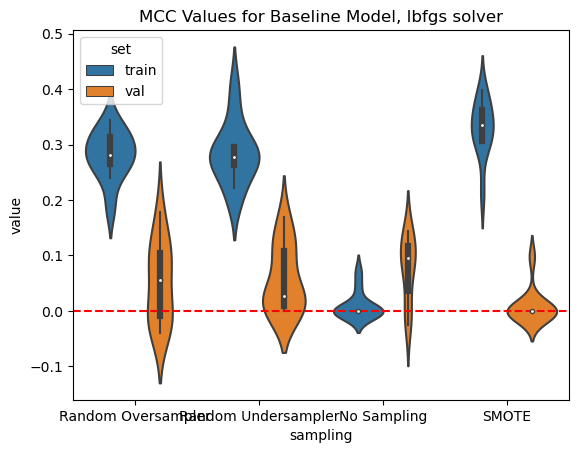

In [16]:
sns.violinplot(data=model_lbfgs_melted[model_lbfgs_melted['met']=='mcc'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('MCC Values for Baseline Model, lbfgs solver')
plt.show()


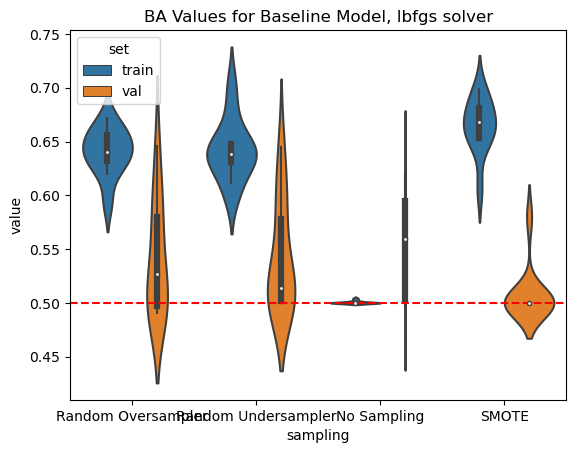

In [17]:
sns.violinplot(data=model_lbfgs_melted[model_lbfgs_melted['met']=='ba'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.title('BA Values for Baseline Model, lbfgs solver')
plt.show()


#### liblinear

In [23]:
start_time = time.time()
model_liblinear = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, 
                                          algorithm='LogisticRegression', solver='liblinear',
                                          multiclass=True))#.to_csv('da_lr_lbfgs.csv')
end_time = time.time()
duration_liblinear = end_time-start_time
print(f"Operation took {duration_liblinear} seconds.")

Operation took 71.7513279914856 seconds.


In [39]:
model_liblinear.to_csv('db_lr_liblinear.csv')
model_liblinear

,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
6,SMOTE,Normalizer + MinMaxScaler,0.290,0.226,0.290,0.200,"[[2060, 0, 6, 0, 30], [1632, 225, 53, 41, 145]...",0.069,0.049,0.216,0.017,"[[0, 0, 0, 27, 1], [1, 19, 0, 564, 114], [0, 0..."
29,RandomOverSampler,Normalizer + StandardScaler,0.350,0.321,0.350,0.245,"[[1949, 0, 96, 26, 25], [1258, 448, 170, 108, ...",0.075,0.058,0.209,0.021,"[[0, 0, 0, 28, 0], [0, 23, 0, 660, 15], [0, 0,..."
26,RandomOverSampler,Normalizer,0.203,0.099,0.203,0.008,"[[0, 126, 1970, 0, 0], [119, 233, 1743, 1, 0],...",0.062,0.057,0.207,0.022,"[[28, 0, 0, 0, 0], [674, 24, 0, 0, 0], [57, 1,..."
4,SMOTE,Normalizer,0.236,0.141,0.236,0.084,"[[2001, 56, 5, 2, 32], [1664, 211, 17, 3, 201]...",0.042,0.042,0.205,0.022,"[[0, 0, 0, 0, 28], [0, 18, 4, 0, 676], [0, 0, ..."
16,RandomUnderSampler,Normalizer + MaxAbsScaler,0.292,0.247,0.292,0.201,"[[3, 0, 49, 0, 0], [0, 12, 40, 0, 0], [0, 3, 4...",0.103,0.077,0.205,0.030,"[[0, 0, 28, 0, 0], [5, 30, 663, 0, 0], [0, 1, ..."
7,SMOTE,Normalizer + StandardScaler,0.372,0.346,0.372,0.288,"[[2005, 1, 82, 0, 8], [1309, 452, 125, 73, 137...",0.040,0.040,0.205,0.017,"[[0, 0, 0, 0, 28], [0, 17, 0, 0, 681], [0, 0, ..."
15,RandomUnderSampler,Normalizer,0.215,0.106,0.215,0.046,"[[0, 3, 49, 0, 0], [0, 7, 45, 0, 0], [0, 3, 49...",0.112,0.094,0.204,0.028,"[[0, 0, 28, 0, 0], [1, 38, 659, 0, 0], [1, 1, ..."
5,SMOTE,Normalizer + MaxAbsScaler,0.290,0.226,0.290,0.201,"[[2062, 0, 6, 0, 28], [1630, 235, 53, 37, 141]...",0.070,0.051,0.203,0.013,"[[0, 0, 0, 28, 0], [1, 20, 0, 621, 56], [0, 0,..."
18,RandomUnderSampler,Normalizer + StandardScaler,0.404,0.395,0.404,0.305,"[[46, 0, 2, 3, 1], [30, 14, 2, 3, 3], [27, 3, ...",0.024,0.005,0.202,-0.000,"[[0, 0, 0, 0, 28], [0, 0, 55, 0, 643], [0, 0, ..."
40,no_sampling,Normalizer + StandardScaler,0.835,0.764,0.226,0.157,"[[2, 80, 0, 0, 0], [0, 2095, 0, 1, 0], [0, 171...",0.090,0.088,0.201,0.021,"[[0, 0, 0, 28, 0], [0, 37, 0, 661, 0], [0, 1, ..."


In [23]:
model_liblinear.to_csv('da_lr_liblinear.csv')
model_liblinear

,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
22,RandomOverSampler,none,0.672,0.676,0.672,0.344,"[[1381, 714], [660, 1435]]",0.672,0.789,0.645,0.177,"[[44, 28], [225, 474]]"
20,RandomUnderSampler,MinMaxScaler + Normalizer,0.631,0.628,0.631,0.263,"[[139, 78], [82, 135]]",0.564,0.696,0.629,0.150,"[[51, 21], [315, 384]]"
19,RandomUnderSampler,MaxAbsScaler + Normalizer,0.611,0.610,0.611,0.221,"[[133, 84], [85, 132]]",0.560,0.693,0.620,0.140,"[[50, 22], [317, 382]]"
43,no_sampling,StandardScaler + Normalizer,0.906,0.951,0.500,0.000,"[[0, 217], [0, 2095]]",0.555,0.690,0.599,0.115,"[[47, 25], [318, 381]]"
11,RandomUnderSampler,none,0.700,0.703,0.700,0.401,"[[150, 67], [63, 154]]",0.604,0.735,0.595,0.112,"[[42, 30], [275, 424]]"
30,RandomOverSampler,MaxAbsScaler + Normalizer,0.620,0.627,0.620,0.240,"[[1261, 834], [758, 1337]]",0.516,0.652,0.590,0.105,"[[49, 23], [350, 349]]"
31,RandomOverSampler,MinMaxScaler + Normalizer,0.628,0.634,0.628,0.256,"[[1276, 819], [741, 1354]]",0.525,0.662,0.582,0.096,"[[47, 25], [341, 358]]"
0,SMOTE,none,0.688,0.686,0.688,0.375,"[[1449, 646], [663, 1432]]",0.647,0.773,0.581,0.099,"[[36, 36], [236, 463]]"
15,RandomUnderSampler,Normalizer,0.599,0.601,0.599,0.198,"[[129, 88], [86, 131]]",0.722,0.831,0.579,0.105,"[[29, 43], [171, 528]]"
26,RandomOverSampler,Normalizer,0.593,0.599,0.593,0.185,"[[1210, 885], [822, 1273]]",0.309,0.395,0.569,0.094,"[[64, 8], [525, 174]]"


In [43]:
model_liblinear_melted = pd.melt(model_liblinear, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_liblinear_melted = model_liblinear_melted.drop(model_liblinear_melted[model_liblinear_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_liblinear_melted['set'] = np.where(model_liblinear_melted['metrics'].str.startswith('train'), 'train', 'val')
model_liblinear_melted['met'] = np.where(model_liblinear_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_liblinear_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_liblinear_melted['sampling'] = np.where(model_liblinear_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_liblinear_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_liblinear_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_liblinear_melted = model_liblinear_melted.drop(columns=['metrics']).sort_values(['sampling', 'set'])
model_liblinear_melted


,sampling,scaling,value,set,met
53,No Sampling,Normalizer + StandardScaler,0.764,train,f1
61,No Sampling,StandardScaler,0.754,train,f1
62,No Sampling,Normalizer + MaxAbsScaler,0.754,train,f1
66,No Sampling,none,0.753,train,f1
67,No Sampling,MaxAbsScaler,0.753,train,f1
...,...,...,...,...,...
322,SMOTE,MaxAbsScaler,0.000,val,mcc
327,SMOTE,none,0.000,val,mcc
336,SMOTE,StandardScaler + Normalizer,-0.009,val,mcc
350,SMOTE,MaxAbsScaler + Normalizer,-0.033,val,mcc


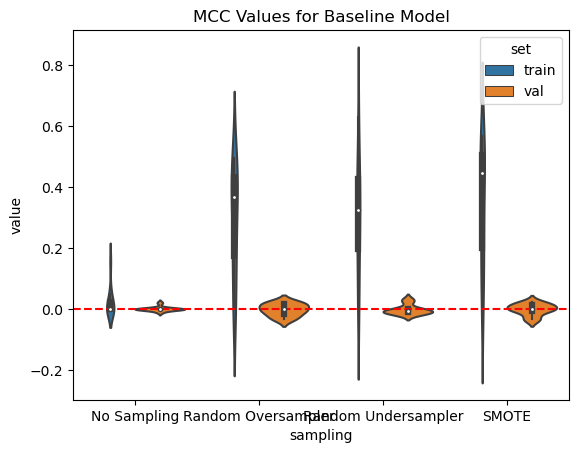

In [44]:
sns.violinplot(data=model_liblinear_melted[model_liblinear_melted['met']=='mcc'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('MCC Values for Baseline Model')
plt.show()


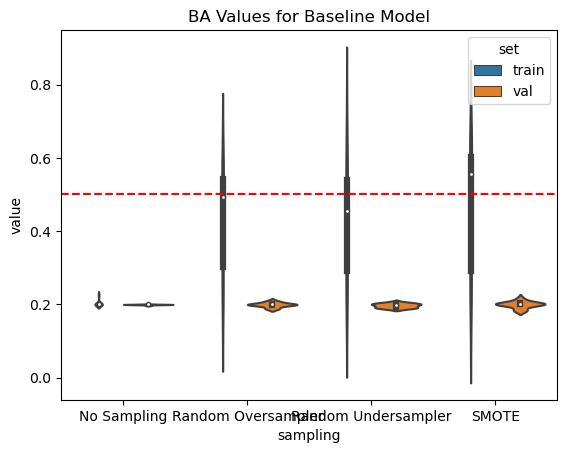

In [45]:
sns.violinplot(data=model_liblinear_melted[model_liblinear_melted['met']=='ba'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.title('BA Values for Baseline Model')
plt.show()


#### saga

In [31]:
start_time = time.time()
model_saga = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, 
                                     multiclass=True,
                                     algorithm='LogisticRegression', solver='saga'))#.to_csv('da_lr_saga.csv')
end_time = time.time()
duration_saga = end_time-start_time
print(f"Operation took {duration_saga} seconds.")
model_saga

Operation took 1638.3135950565338 seconds.


,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
38,no_sampling,Normalizer + MaxAbsScaler,0.830,0.754,0.202,0.046,"[[0, 82, 0, 0, 0], [0, 2096, 0, 0, 0], [0, 174...",0.476,0.556,0.239,0.077,"[[0, 7, 0, 21, 0], [0, 374, 0, 324, 0], [0, 28..."
40,no_sampling,Normalizer + StandardScaler,0.836,0.767,0.231,0.176,"[[3, 79, 0, 0, 0], [0, 2095, 0, 1, 0], [0, 171...",0.096,0.097,0.215,0.043,"[[0, 0, 0, 28, 0], [0, 38, 9, 651, 0], [0, 1, ..."
37,no_sampling,Normalizer,0.830,0.753,0.200,0.000,"[[0, 82, 0, 0, 0], [0, 2096, 0, 0, 0], [0, 174...",0.083,0.096,0.212,0.031,"[[28, 0, 0, 0, 0], [656, 42, 0, 0, 0], [56, 2,..."
14,RandomUnderSampler,StandardScaler,0.746,0.746,0.746,0.683,"[[42, 2, 5, 2, 1], [3, 38, 3, 3, 5], [0, 4, 39...",0.053,0.011,0.211,0.015,"[[0, 0, 0, 28, 0], [4, 0, 58, 636, 0], [0, 0, ..."
29,RandomOverSampler,Normalizer + StandardScaler,0.348,0.319,0.348,0.239,"[[1949, 0, 72, 75, 0], [1244, 436, 179, 133, 1...",0.082,0.071,0.210,0.022,"[[0, 0, 0, 28, 0], [0, 29, 0, 645, 24], [0, 1,..."
26,RandomOverSampler,Normalizer,0.204,0.098,0.204,0.010,"[[0, 126, 1970, 0, 0], [135, 221, 1740, 0, 0],...",0.058,0.051,0.206,0.033,"[[28, 0, 0, 0, 0], [677, 21, 0, 0, 0], [58, 0,..."
17,RandomUnderSampler,Normalizer + MinMaxScaler,0.338,0.301,0.338,0.203,"[[42, 0, 9, 0, 1], [24, 12, 16, 0, 0], [26, 2,...",0.106,0.081,0.206,0.027,"[[0, 0, 28, 0, 0], [4, 32, 662, 0, 0], [0, 1, ..."
7,SMOTE,Normalizer + StandardScaler,0.368,0.346,0.368,0.280,"[[1969, 6, 89, 32, 0], [1302, 440, 147, 87, 12...",0.043,0.045,0.205,0.020,"[[0, 0, 0, 0, 28], [0, 19, 0, 0, 679], [0, 0, ..."
15,RandomUnderSampler,Normalizer,0.215,0.106,0.215,0.044,"[[0, 3, 49, 0, 0], [1, 7, 44, 0, 0], [0, 3, 49...",0.103,0.077,0.205,0.024,"[[0, 0, 28, 0, 0], [5, 30, 663, 0, 0], [0, 1, ..."
5,SMOTE,Normalizer + MaxAbsScaler,0.294,0.232,0.294,0.208,"[[2063, 0, 5, 0, 28], [1623, 236, 50, 37, 150]...",0.040,0.040,0.205,0.015,"[[0, 0, 0, 0, 28], [2, 17, 0, 1, 678], [0, 0, ..."


In [40]:
model_saga.to_csv('db_lr_saga.csv')

In [46]:
model_saga_melted = pd.melt(model_saga, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_saga_melted = model_saga_melted.drop(model_saga_melted[model_saga_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_saga_melted['set'] = np.where(model_saga_melted['metrics'].str.startswith('train'), 'train', 'val')
model_saga_melted['met'] = np.where(model_saga_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_saga_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_saga_melted['sampling'] = np.where(model_saga_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_saga_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_saga_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_saga_melted = model_saga_melted.drop(columns=['metrics']).sort_values(['sampling', 'set'])
model_saga_melted


,sampling,scaling,value,set,met
44,No Sampling,Normalizer + MaxAbsScaler,0.754,train,f1
45,No Sampling,Normalizer + StandardScaler,0.767,train,f1
46,No Sampling,Normalizer,0.753,train,f1
64,No Sampling,StandardScaler,0.761,train,f1
65,No Sampling,Normalizer + MinMaxScaler,0.754,train,f1
...,...,...,...,...,...
323,SMOTE,MinMaxScaler,0.000,val,mcc
324,SMOTE,MaxAbsScaler,0.000,val,mcc
330,SMOTE,none,0.000,val,mcc
350,SMOTE,MaxAbsScaler + Normalizer,-0.038,val,mcc


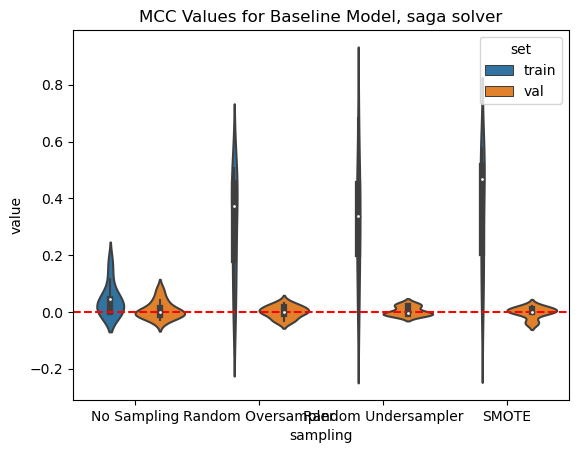

In [47]:
sns.violinplot(data=model_saga_melted[model_saga_melted['met']=='mcc'], 
               x='sampling', y='value', hue='set',)
plt.title('MCC Values for Baseline Model, saga solver')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


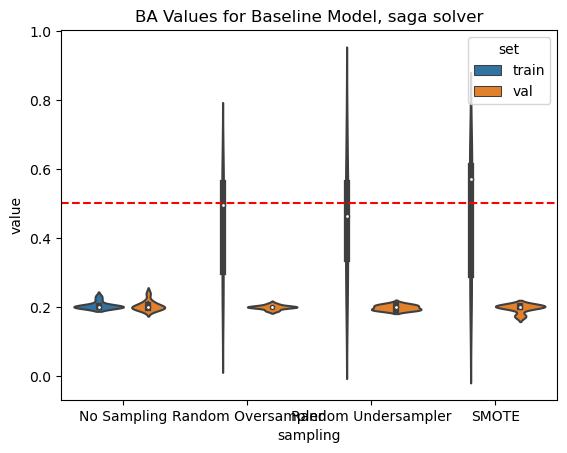

In [48]:
sns.violinplot(data=model_saga_melted[model_saga_melted['met']=='ba'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.title('BA Values for Baseline Model, saga solver')
plt.show()


#### plot for all solvers

In [55]:
model_liblinear_melted[model_liblinear_melted['met']=='ba'].sort_values(['value'])

,sampling,scaling,value,set,met
307,SMOTE,MinMaxScaler + Normalizer,0.184,val,ba
306,SMOTE,MaxAbsScaler + Normalizer,0.184,val,ba
304,Random Oversampler,MaxAbsScaler + Normalizer,0.189,val,ba
305,Random Oversampler,MinMaxScaler + Normalizer,0.189,val,ba
301,Random Undersampler,MaxAbsScaler + Normalizer,0.190,val,ba
...,...,...,...,...,...
102,SMOTE,MaxAbsScaler,0.600,train,ba
101,SMOTE,MinMaxScaler,0.602,train,ba
116,SMOTE,StandardScaler + Normalizer,0.604,train,ba
100,SMOTE,StandardScaler,0.652,train,ba


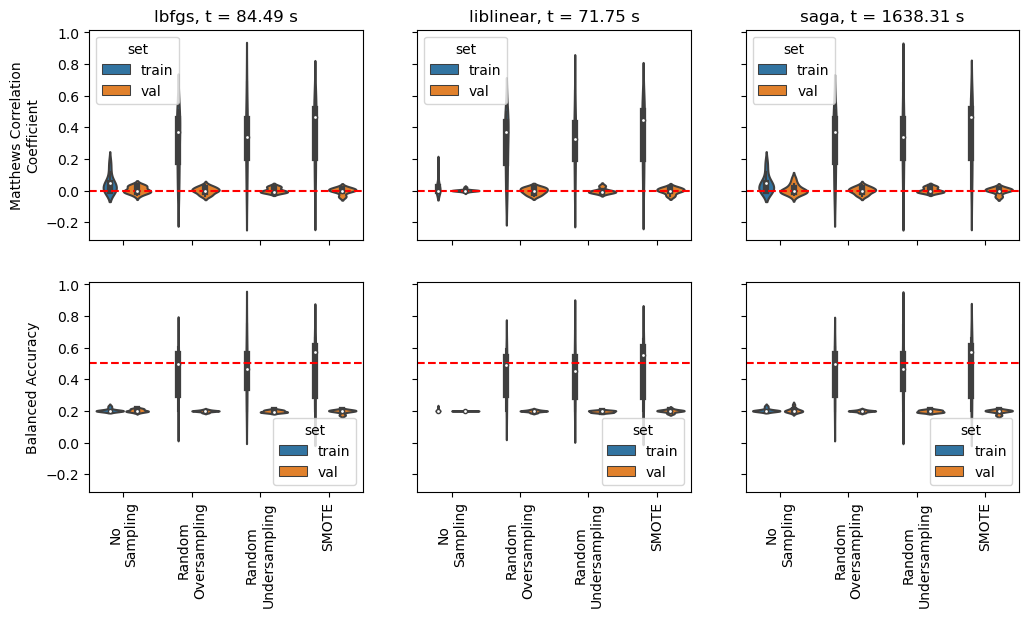

In [41]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 6), sharex=True, sharey=True)

ax[0, 0].set_title(f'lbfgs, t = {round(duration_lbfgs, 2)} s')
ax[0, 1].set_title(f'liblinear, t = {round(duration_liblinear, 2)} s')
ax[0, 2].set_title(f'saga, t = {round(duration_saga, 2)} s')

for i, j in enumerate([model_lbfgs_melted, model_liblinear_melted, model_saga_melted]):
    sns.violinplot(data=j[j['met']=='mcc'].sort_values(['sampling', 'set']), x='sampling', y='value', hue='set', ax=ax[0, i])
    sns.violinplot(data=j[j['met']=='ba'].sort_values(['sampling', 'set']), x='sampling', y='value', hue='set', ax=ax[1, i])
    ax[0, i].axhline(y=0, color='r', linestyle='--')
    ax[1, i].axhline(y=0.5, color='r', linestyle='--')
    ax[1, i].set_xticklabels(ax[1, i].get_xticklabels(), rotation=90, ha='center')
    ax[0, i].set_xlabel('')
    ax[1, i].set_xlabel('')
    ax[0, i].set_ylabel('')
    ax[1, i].set_ylabel('')
    ax[0, 0].set_ylabel('Matthews Correlation\nCoefficient')
    ax[1, 0].set_ylabel('Balanced Accuracy')
plt.setp(ax,
         yticks=[-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1],
         xticklabels=['No\nSampling',  'Random\nOversampling', 'Random\nUndersampling', 'SMOTE'],
)
plt.show()

In [56]:
model_liblinear#_melted

,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
6,SMOTE,Normalizer + MinMaxScaler,0.290,0.226,0.290,0.200,"[[2060, 0, 6, 0, 30], [1632, 225, 53, 41, 145]...",0.069,0.049,0.216,0.017,"[[0, 0, 0, 27, 1], [1, 19, 0, 564, 114], [0, 0..."
29,RandomOverSampler,Normalizer + StandardScaler,0.350,0.321,0.350,0.245,"[[1949, 0, 96, 26, 25], [1258, 448, 170, 108, ...",0.075,0.058,0.209,0.021,"[[0, 0, 0, 28, 0], [0, 23, 0, 660, 15], [0, 0,..."
26,RandomOverSampler,Normalizer,0.203,0.099,0.203,0.008,"[[0, 126, 1970, 0, 0], [119, 233, 1743, 1, 0],...",0.062,0.057,0.207,0.022,"[[28, 0, 0, 0, 0], [674, 24, 0, 0, 0], [57, 1,..."
4,SMOTE,Normalizer,0.236,0.141,0.236,0.084,"[[2001, 56, 5, 2, 32], [1664, 211, 17, 3, 201]...",0.042,0.042,0.205,0.022,"[[0, 0, 0, 0, 28], [0, 18, 4, 0, 676], [0, 0, ..."
16,RandomUnderSampler,Normalizer + MaxAbsScaler,0.292,0.247,0.292,0.201,"[[3, 0, 49, 0, 0], [0, 12, 40, 0, 0], [0, 3, 4...",0.103,0.077,0.205,0.030,"[[0, 0, 28, 0, 0], [5, 30, 663, 0, 0], [0, 1, ..."
7,SMOTE,Normalizer + StandardScaler,0.372,0.346,0.372,0.288,"[[2005, 1, 82, 0, 8], [1309, 452, 125, 73, 137...",0.040,0.040,0.205,0.017,"[[0, 0, 0, 0, 28], [0, 17, 0, 0, 681], [0, 0, ..."
15,RandomUnderSampler,Normalizer,0.215,0.106,0.215,0.046,"[[0, 3, 49, 0, 0], [0, 7, 45, 0, 0], [0, 3, 49...",0.112,0.094,0.204,0.028,"[[0, 0, 28, 0, 0], [1, 38, 659, 0, 0], [1, 1, ..."
5,SMOTE,Normalizer + MaxAbsScaler,0.290,0.226,0.290,0.201,"[[2062, 0, 6, 0, 28], [1630, 235, 53, 37, 141]...",0.070,0.051,0.203,0.013,"[[0, 0, 0, 28, 0], [1, 20, 0, 621, 56], [0, 0,..."
18,RandomUnderSampler,Normalizer + StandardScaler,0.404,0.395,0.404,0.305,"[[46, 0, 2, 3, 1], [30, 14, 2, 3, 3], [27, 3, ...",0.024,0.005,0.202,-0.000,"[[0, 0, 0, 0, 28], [0, 0, 55, 0, 643], [0, 0, ..."
40,no_sampling,Normalizer + StandardScaler,0.835,0.764,0.226,0.157,"[[2, 80, 0, 0, 0], [0, 2095, 0, 1, 0], [0, 171...",0.090,0.088,0.201,0.021,"[[0, 0, 0, 28, 0], [0, 37, 0, 661, 0], [0, 1, ..."


## feature importance

In [68]:
solver='liblinear'
max_iter=10000
random_state=0

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)

X_train, y_train  = RandomUnderSampler(random_state=random_state).fit_resample(X_train, y_train)
X_train = preprocessing.MinMaxScaler().fit_transform(X_train)
X_train = preprocessing.Normalizer().fit_transform(X_train)

# create final model in linreg
lr = LogisticRegression(solver=solver,max_iter=max_iter, random_state=random_state)
fit = lr.fit(X_train, y_train)
y_pred = fit.predict(X_train)
y_val_pred = fit.predict(X_val)

# calculate statistical metrics for training set
train_f1 = metrics.f1_score(y_train, y_pred, average = 'binary')
train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
train_cf = metrics.confusion_matrix(y_train, y_pred)

# calculate statistical metrics for val set
val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'binary')
val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
val_cf = metrics.confusion_matrix(y_val, y_val_pred)

print(f'train scores \n')
print(f'f1: {train_f1:.3f}')
print(f'balanced accuracy: {train_ba:.3f}')
print(f'matthews corrcoeff: {train_mcc:.3f}')
print(f'cf:\n{train_cf}')
print('')
print(f'val scores \n')
print(f'f1: {val_f1:.3f}')
print(f'balanced accuracy: {val_ba:.3f}')
print(f'matthews corrcoeff: {val_mcc:.3f}')
print(f'cf:\n{val_cf}')


train scores 

f1: 0.628
balanced accuracy: 0.631
matthews corrcoeff: 0.263
cf:
[[139  78]
 [ 82 135]]

val scores 

f1: 0.696
balanced accuracy: 0.629
matthews corrcoeff: 0.150
cf:
[[ 51  21]
 [315 384]]


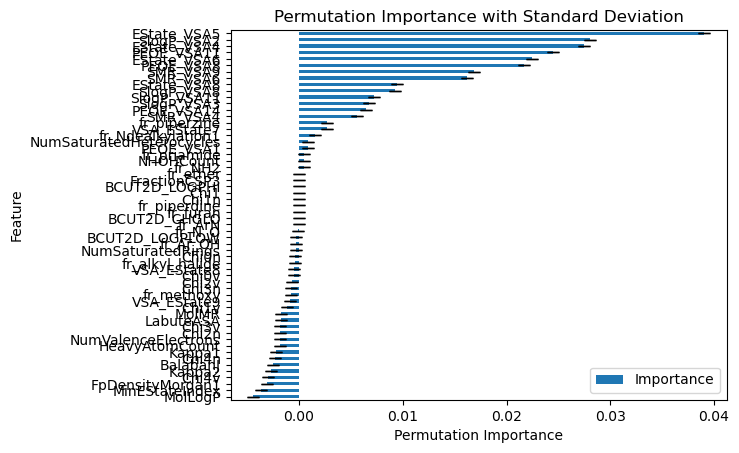

In [41]:
result = permutation_importance(fit, X_val, y_val, n_repeats=10, random_state=random_state)

feature_importance = pd.DataFrame({'Feature': descnm,
                                   'Importance': result.importances_mean,
                                   'Standard Deviation': result.importances_std})
feature_importance = feature_importance.sort_values('Importance', ascending=True)


ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', 
                             
                            yerr='Standard Deviation', capsize=4)
ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance with Standard Deviation')
plt.tight_layout
plt.show()

In [45]:
feature_importance[feature_importance['Importance'] > 0].Feature.to_list()

['fr_NH2',
 'NHOHCount',
 'fr_priamide',
 'PEOE_VSA1',
 'NumSaturatedHeterocycles',
 'fr_Ndealkylation1',
 'VSA_EState7',
 'fr_piperzine',
 'SMR_VSA4',
 'PEOE_VSA14',
 'SlogP_VSA3',
 'SlogP_VSA11',
 'SlogP_VSA8',
 'EState_VSA8',
 'SMR_VSA6',
 'SMR_VSA9',
 'PEOE_VSA8',
 'EState_VSA6',
 'PEOE_VSA11',
 'EState_VSA4',
 'SlogP_VSA2',
 'EState_VSA5']

### retrain

In [62]:
solver='liblinear'
max_iter=10000
random_state=0

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da[features_])

X_train, y_train  = RandomUnderSampler(random_state=random_state).fit_resample(X_train, y_train)
X_train = preprocessing.MinMaxScaler().fit_transform(X_train)
X_train = preprocessing.Normalizer().fit_transform(X_train)

# create final model in linreg
lr = LogisticRegression(solver=solver,max_iter=max_iter, random_state=random_state)
fit = lr.fit(X_train, y_train)
y_pred = fit.predict(X_train)
y_val_pred = fit.predict(X_val)

# calculate statistical metrics for training set
train_f1 = metrics.f1_score(y_train, y_pred, average = 'binary')
train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
train_cf = metrics.confusion_matrix(y_train, y_pred)

# calculate statistical metrics for val set
val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'binary')
val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
val_cf = metrics.confusion_matrix(y_val, y_val_pred)

print(f'train scores \n')
print(f'f1: {train_f1:.3f}')
print(f'balanced accuracy: {train_ba:.3f}')
print(f'matthews corrcoeff: {train_mcc:.3f}')
print(f'cf:\n{train_cf}')
print('')
print(f'val scores \n')
print(f'f1: {val_f1:.3f}')
print(f'balanced accuracy: {val_ba:.3f}')
print(f'matthews corrcoeff: {val_mcc:.3f}')
print(f'cf:\n{val_cf}')


train scores 

f1: 0.593
balanced accuracy: 0.604
matthews corrcoeff: 0.209
cf:
[[127  74]
 [ 85 116]]

val scores 

f1: 0.159
balanced accuracy: 0.521
matthews corrcoeff: 0.047
cf:
[[ 64   3]
 [505  48]]


## hyperparameter tuning using gridsearch

In [65]:
X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)

In [70]:
def grid_search(X_train, y_train,
                param_grid,
                algorithm = 'LogisticRegression',
                fold = 3,
                scoring='balanced_accuracy',
                random_state=0,
                ):
    
    if algorithm == 'LogisticRegression':
        model = LogisticRegression(random_state=random_state)
    elif algorithm == 'SVC':
        model = SVC(random_state=random_state)
    elif algorithm == 'RandomForestClassifier':
        model = RandomForestClassifier(random_state=random_state)
    else:
        pass

    cv_ = model_selection.GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=fold,
        verbose=3,
        scoring=scoring,
        )
    cv_.fit(X_train, y_train)

    return cv_.best_params_


In [79]:
param_grid = {
    'solver': ['liblinear',],
    'penalty': ['l1', 'l2'],
    'class_weight':[None, 'balanced'],
    'C': [1, 10, 100, 1000],
    'max_iter': [10000],
    'random_state':[0]
}

grid_search(X_train, y_train,
            param_grid,
            algorithm='LogisticRegression',
            )

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END C=1, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.517 total time=   0.0s
[CV 2/3] END C=1, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.497 total time=   0.0s
[CV 3/3] END C=1, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.444 total time=   0.0s
[CV 1/3] END C=1, class_weight=None, max_iter=10000, penalty=l2, random_state=0, solver=liblinear;, score=0.551 total time=   0.0s
[CV 2/3] END C=1, class_weight=None, max_iter=10000, penalty=l2, random_state=0, solver=liblinear;, score=0.531 total time=   0.0s
[CV 3/3] END C=1, class_weight=None, max_iter=10000, penalty=l2, random_state=0, solver=liblinear;, score=0.514 total time=   0.0s
[CV 1/3] END C=1, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.517 total time=   0.0s
[CV 2/3] END C=1, 

[CV 2/3] END C=10, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.552 total time=   0.0s
[CV 3/3] END C=10, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.576 total time=   0.2s
[CV 1/3] END C=10, class_weight=None, max_iter=10000, penalty=l2, random_state=0, solver=liblinear;, score=0.558 total time=   0.0s
[CV 2/3] END C=10, class_weight=None, max_iter=10000, penalty=l2, random_state=0, solver=liblinear;, score=0.558 total time=   0.0s
[CV 3/3] END C=10, class_weight=None, max_iter=10000, penalty=l2, random_state=0, solver=liblinear;, score=0.542 total time=   0.0s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.545 total time=   0.1s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.552 total time=   0.0s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, penalty=l1

{'C': 10,
 'class_weight': None,
 'max_iter': 10000,
 'penalty': 'l1',
 'random_state': 0,
 'solver': 'liblinear'}

In [81]:
solver='liblinear'
max_iter=10000
random_state=0
C=10
penalty='l1'

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)

X_train, y_train  = RandomUnderSampler(random_state=random_state).fit_resample(X_train, y_train)
X_train = preprocessing.MinMaxScaler().fit_transform(X_train)
X_train = preprocessing.Normalizer().fit_transform(X_train)

# create final model in linreg
lr = LogisticRegression(solver=solver,max_iter=max_iter, random_state=random_state, C=C, penalty=penalty)
fit = lr.fit(X_train, y_train)
y_pred = fit.predict(X_train)
y_val_pred = fit.predict(X_val)

# calculate statistical metrics for training set
train_f1 = metrics.f1_score(y_train, y_pred, average = 'binary')
train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
train_cf = metrics.confusion_matrix(y_train, y_pred)

# calculate statistical metrics for val set
val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'binary')
val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
val_cf = metrics.confusion_matrix(y_val, y_val_pred)

print(f'train scores \n')
print(f'f1: {train_f1:.3f}')
print(f'balanced accuracy: {train_ba:.3f}')
print(f'matthews corrcoeff: {train_mcc:.3f}')
print(f'cf:\n{train_cf}')
print('')
print(f'val scores \n')
print(f'f1: {val_f1:.3f}')
print(f'balanced accuracy: {val_ba:.3f}')
print(f'matthews corrcoeff: {val_mcc:.3f}')
print(f'cf:\n{val_cf}')


train scores 

f1: 0.636
balanced accuracy: 0.638
matthews corrcoeff: 0.277
cf:
[[140  77]
 [ 80 137]]

val scores 

f1: 0.628
balanced accuracy: 0.596
matthews corrcoeff: 0.113
cf:
[[ 52  20]
 [370 329]]


# svm

In [98]:
X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)

## linear

In [10]:
start_time = time.time()
model_linear = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, algorithm='SVC', kernel='linear'))
model_linear.to_csv('da_svm_linear.csv')
end_time = time.time()
duration_linear = end_time-start_time
print(f"Operation took {duration_linear} seconds.")

Operation took 908.036052942276 seconds.


In [12]:
model_linear

,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
22,RandomOverSampler,none,0.678,0.670,0.678,0.356,"[[1471, 624], [726, 1369]]",0.646,0.768,0.649,0.178,"[[47, 25], [248, 451]]"
20,RandomUnderSampler,MinMaxScaler + Normalizer,0.634,0.626,0.634,0.268,"[[142, 75], [84, 133]]",0.440,0.560,0.641,0.170,"[[64, 8], [424, 275]]"
19,RandomUnderSampler,MaxAbsScaler + Normalizer,0.604,0.576,0.604,0.209,"[[145, 72], [100, 117]]",0.673,0.791,0.627,0.156,"[[41, 31], [221, 478]]"
21,RandomUnderSampler,StandardScaler + Normalizer,0.647,0.665,0.647,0.297,"[[129, 88], [65, 152]]",0.603,0.733,0.619,0.140,"[[46, 26], [280, 419]]"
11,RandomUnderSampler,none,0.721,0.723,0.721,0.442,"[[155, 62], [59, 158]]",0.608,0.738,0.610,0.130,"[[44, 28], [274, 425]]"
12,RandomUnderSampler,MaxAbsScaler,0.618,0.639,0.618,0.237,"[[121, 96], [70, 147]]",0.702,0.815,0.599,0.126,"[[34, 38], [192, 507]]"
13,RandomUnderSampler,MinMaxScaler,0.627,0.645,0.627,0.255,"[[125, 92], [70, 147]]",0.711,0.822,0.598,0.126,"[[33, 39], [184, 515]]"
0,SMOTE,none,0.700,0.678,0.700,0.405,"[[1615, 480], [775, 1320]]",0.594,0.728,0.571,0.083,"[[39, 33], [280, 419]]"
15,RandomUnderSampler,Normalizer,0.571,0.480,0.571,0.153,"[[162, 55], [131, 86]]",0.792,0.881,0.537,0.059,"[[16, 56], [104, 595]]"
23,RandomOverSampler,MaxAbsScaler,0.659,0.663,0.659,0.319,"[[1357, 738], [689, 1406]]",0.843,0.914,0.527,0.056,"[[10, 62], [59, 640]]"


In [15]:
model_linear_melted = pd.melt(model_linear, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_linear_melted = model_linear_melted.drop(model_linear_melted[model_linear_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_linear_melted['set'] = np.where(model_linear_melted['metrics'].str.startswith('train'), 'train', 'val')
model_linear_melted['met'] = np.where(model_linear_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_linear_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_linear_melted['sampling'] = np.where(model_linear_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_linear_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_linear_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_linear_melted = model_linear_melted.drop(columns=['metrics']).sort_values(['sampling', 'set'])
model_linear_melted


,sampling,scaling,value,set,met
74,No Sampling,none,0.951,train,f1
75,No Sampling,MaxAbsScaler,0.951,train,f1
76,No Sampling,MinMaxScaler,0.951,train,f1
77,No Sampling,StandardScaler,0.951,train,f1
78,No Sampling,Normalizer,0.951,train,f1
...,...,...,...,...,...
330,SMOTE,Normalizer + MaxAbsScaler,0.000,val,mcc
332,SMOTE,MinMaxScaler + Normalizer,0.000,val,mcc
333,SMOTE,MaxAbsScaler + Normalizer,0.000,val,mcc
336,SMOTE,StandardScaler + Normalizer,0.000,val,mcc


In [17]:
model_linear_melted[model_linear_melted['met']=='mcc']

,sampling,scaling,value,set,met
162,No Sampling,none,0.0,train,mcc
163,No Sampling,MaxAbsScaler,0.0,train,mcc
164,No Sampling,MinMaxScaler,0.0,train,mcc
165,No Sampling,StandardScaler,0.0,train,mcc
166,No Sampling,Normalizer,0.0,train,mcc
...,...,...,...,...,...
330,SMOTE,Normalizer + MaxAbsScaler,0.0,val,mcc
332,SMOTE,MinMaxScaler + Normalizer,0.0,val,mcc
333,SMOTE,MaxAbsScaler + Normalizer,0.0,val,mcc
336,SMOTE,StandardScaler + Normalizer,0.0,val,mcc


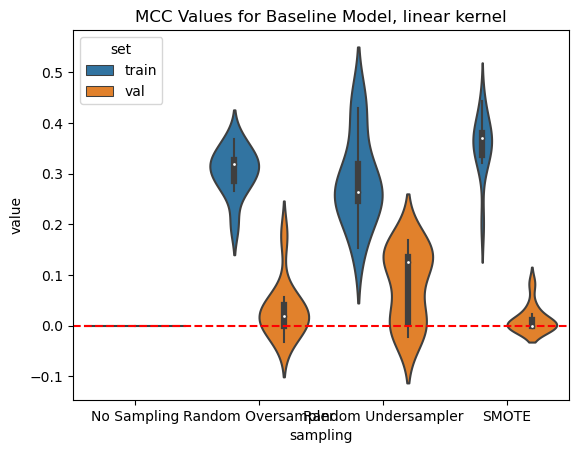

In [16]:
sns.violinplot(data=model_linear_melted[model_linear_melted['met']=='mcc'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('MCC Values for Baseline Model, linear kernel')
plt.show()


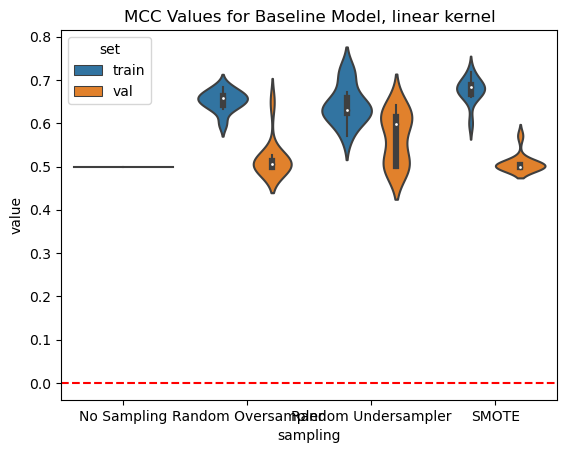

In [18]:
sns.violinplot(data=model_linear_melted[model_linear_melted['met']=='ba'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('MCC Values for Baseline Model, linear kernel')
plt.show()


## poly

In [21]:
start_time = time.time()
model_poly = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, algorithm='SVC', kernel='poly'))
model_poly.to_csv('da_svm_poly.csv')
end_time = time.time()
duration_poly = end_time-start_time
print(f"Operation took {duration_poly} seconds.")

Operation took 111.60832214355469 seconds.


In [28]:
model_poly_melted = pd.melt(model_poly, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_poly_melted = model_poly_melted.drop(model_poly_melted[model_poly_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_poly_melted['set'] = np.where(model_poly_melted['metrics'].str.startswith('train'), 'train', 'val')
model_poly_melted['met'] = np.where(model_poly_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_poly_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_poly_melted['sampling'] = np.where(model_poly_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_poly_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_poly_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_poly_melted = model_poly_melted.drop(columns=['metrics']).sort_values(['sampling', 'set'])
model_poly_melted


,sampling,scaling,value,set,met
47,No Sampling,Normalizer + MaxAbsScaler,0.951,train,f1
55,No Sampling,Normalizer + StandardScaler,0.958,train,f1
56,No Sampling,StandardScaler + Normalizer,0.957,train,f1
60,No Sampling,Normalizer,0.951,train,f1
79,No Sampling,none,0.951,train,f1
...,...,...,...,...,...
333,SMOTE,MinMaxScaler,0.000,val,mcc
336,SMOTE,MaxAbsScaler,0.000,val,mcc
337,SMOTE,Normalizer + MinMaxScaler,0.000,val,mcc
341,SMOTE,Normalizer + MaxAbsScaler,0.000,val,mcc


In [30]:
model_poly_melted.sampling.unique()

array(['No Sampling', 'Random Oversampler', 'Random Undersampler',
       'SMOTE'], dtype=object)

In [31]:
model_poly_melted[model_poly_melted['sampling']=='Random Oversampler']

,sampling,scaling,value,set,met
48,Random Oversampler,none,0.670,train,f1
51,Random Oversampler,MinMaxScaler + Normalizer,0.814,train,f1
52,Random Oversampler,Normalizer,0.617,train,f1
57,Random Oversampler,StandardScaler,0.876,train,f1
62,Random Oversampler,Normalizer + StandardScaler,0.894,train,f1
...,...,...,...,...,...
331,Random Oversampler,StandardScaler + Normalizer,0.000,val,mcc
334,Random Oversampler,MinMaxScaler,0.000,val,mcc
338,Random Oversampler,Normalizer + MinMaxScaler,0.000,val,mcc
339,Random Oversampler,MaxAbsScaler + Normalizer,0.000,val,mcc


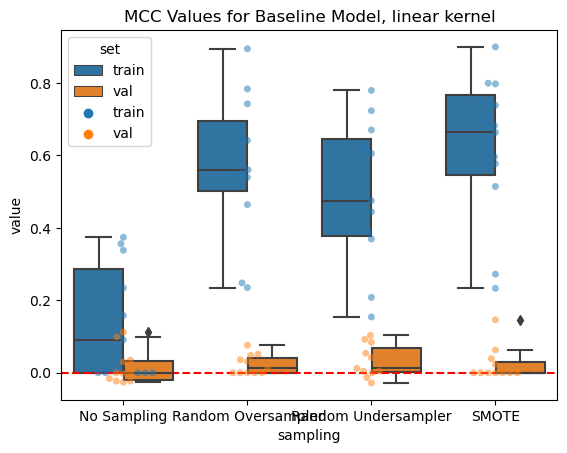

In [34]:
sns.boxplot(data=model_poly_melted[model_poly_melted['met']=='mcc'], 
               x='sampling', y='value', hue='set',)
sns.swarmplot(data=model_poly_melted[model_poly_melted['met']=='mcc'], 
               x='sampling', y='value', hue='set', alpha=0.5,)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('MCC Values for Baseline Model, linear kernel')
plt.show()


## rbf

In [19]:
start_time = time.time()
model_rbf = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, algorithm='SVC', kernel='rbf'))
model_rbf.to_csv('da_svm_rbf.csv')
end_time = time.time()
duration_rbf = end_time-start_time
print(f"Operation took {duration_rbf} seconds.")

Operation took 245.0490140914917 seconds.


In [20]:
model_rbf_melted = pd.melt(model_rbf, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_rbf_melted = model_rbf_melted.drop(model_rbf_melted[model_rbf_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_rbf_melted['set'] = np.where(model_rbf_melted['metrics'].str.startswith('train'), 'train', 'val')
model_rbf_melted['met'] = np.where(model_rbf_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_rbf_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_rbf_melted['sampling'] = np.where(model_rbf_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_rbf_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_rbf_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_rbf_melted = model_rbf_melted.drop(columns=['metrics']).sort_values(['sampling', 'set'])
model_rbf_melted


,sampling,scaling,value,set,met
77,No Sampling,StandardScaler + Normalizer,0.953,train,f1
78,No Sampling,StandardScaler,0.953,train,f1
79,No Sampling,Normalizer + StandardScaler,0.952,train,f1
80,No Sampling,none,0.951,train,f1
81,No Sampling,MaxAbsScaler,0.951,train,f1
...,...,...,...,...,...
322,SMOTE,MaxAbsScaler,0.000,val,mcc
323,SMOTE,MaxAbsScaler + Normalizer,0.000,val,mcc
328,SMOTE,Normalizer + MinMaxScaler,0.000,val,mcc
330,SMOTE,Normalizer + MaxAbsScaler,0.000,val,mcc


## sigmoid

In [23]:
start_time = time.time()
model_sigmoid = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, algorithm='SVC', kernel='sigmoid'))
model_sigmoid.to_csv('da_svm_sigmoid.csv')
end_time = time.time()
duration_sigmoid = end_time-start_time
print(f"Operation took {duration_sigmoid} seconds.")

Operation took 145.55909991264343 seconds.


In [24]:
model_sigmoid_melted = pd.melt(model_sigmoid, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_sigmoid_melted = model_sigmoid_melted.drop(model_sigmoid_melted[model_sigmoid_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_sigmoid_melted['set'] = np.where(model_sigmoid_melted['metrics'].str.startswith('train'), 'train', 'val')
model_sigmoid_melted['met'] = np.where(model_sigmoid_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_sigmoid_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_sigmoid_melted['sampling'] = np.where(model_sigmoid_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_sigmoid_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_sigmoid_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_sigmoid_melted = model_sigmoid_melted.drop(columns=['metrics']).sort_values(['sampling', 'set'])
model_sigmoid_melted


,sampling,scaling,value,set,met
47,No Sampling,none,0.918,train,f1
51,No Sampling,StandardScaler + Normalizer,0.937,train,f1
76,No Sampling,Normalizer + StandardScaler,0.927,train,f1
77,No Sampling,MaxAbsScaler,0.932,train,f1
78,No Sampling,Normalizer,0.951,train,f1
...,...,...,...,...,...
333,SMOTE,MaxAbsScaler,0.000,val,mcc
334,SMOTE,Normalizer + MinMaxScaler,0.000,val,mcc
335,SMOTE,StandardScaler + Normalizer,0.000,val,mcc
339,SMOTE,MaxAbsScaler + Normalizer,0.000,val,mcc


## plot for all kernels

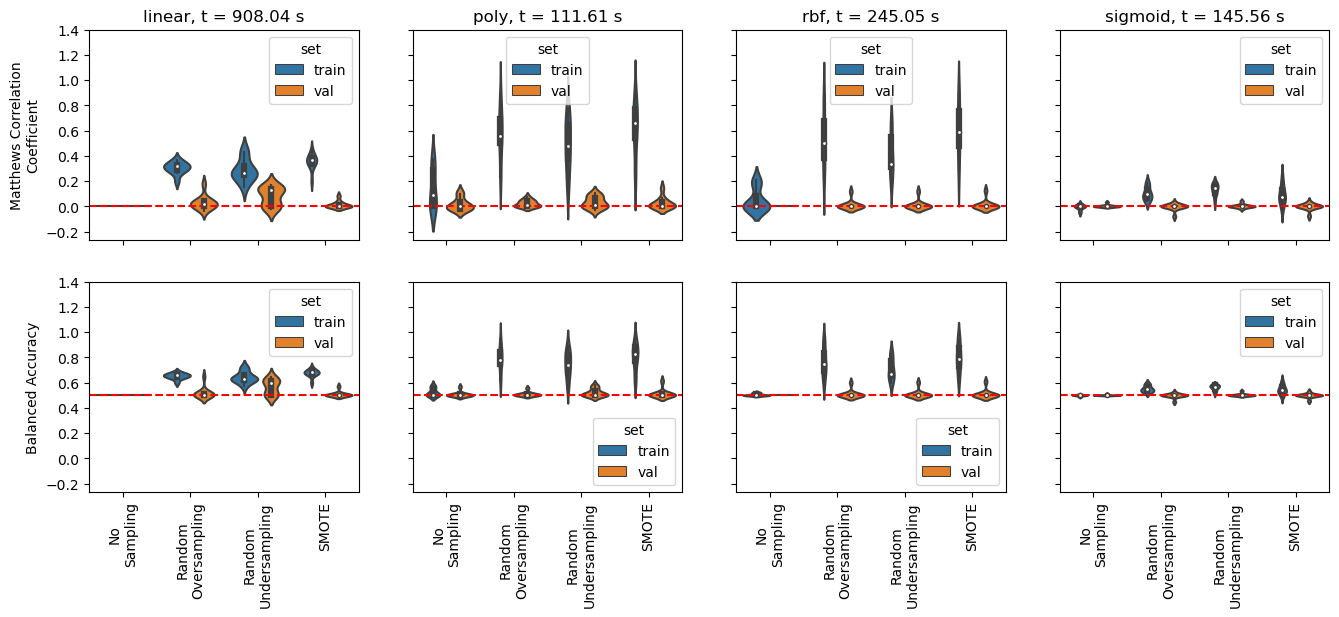

In [37]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16, 6), sharex=True, sharey=True)

ax[0, 0].set_title(f'linear, t = {round(duration_linear, 2)} s')
ax[0, 1].set_title(f'poly, t = {round(duration_poly, 2)} s')
ax[0, 2].set_title(f'rbf, t = {round(duration_rbf, 2)} s')
ax[0, 3].set_title(f'sigmoid, t = {round(duration_sigmoid, 2)} s')

for i, j in enumerate([model_linear_melted, model_poly_melted, model_rbf_melted, model_sigmoid_melted]):
    sns.violinplot(data=j[j['met']=='mcc'], x='sampling', y='value', hue='set', ax=ax[0, i])
    sns.violinplot(data=j[j['met']=='ba'], x='sampling', y='value', hue='set', ax=ax[1, i])
    ax[0, i].axhline(y=0, color='r', linestyle='--')
    ax[1, i].axhline(y=0.5, color='r', linestyle='--')
    ax[1, i].set_xticklabels(ax[1, i].get_xticklabels(), rotation=90, ha='center')
    ax[0, i].set_xlabel('')
    ax[1, i].set_xlabel('')
    ax[0, i].set_ylabel('')
    ax[1, i].set_ylabel('')
    ax[0, 0].set_ylabel('Matthews Correlation\nCoefficient')
    ax[1, 0].set_ylabel('Balanced Accuracy')
plt.setp(ax,
         yticks=[-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4],
         xticklabels=['No\nSampling',  'Random\nOversampling', 'Random\nUndersampling', 'SMOTE'],
)
plt.show()

## feature importance

## hyperparameter tuninr

# rf